# Part 2

market1_train.csv contains time series observations for 100 different entities ID0, ID1, ..., ID99. market2_train.csv is similar. You will find that there is some correlation across entities within a market and that the two markets are independent of each other.

For each entity in each market, predict the value of the time series for the next 20 time periods (2021-07-10 through 2021-07-29). Save your predictions for the first dataset in a csv file named market1_pred.csv with the same format as market1_train.csv (and similarly for predictions on the second dataset).

When assessing your submission, we will note the accuracy of your predictions, but mostly we will focus on whether you made an effort to validate your model's performance using a hold-out test set. Be sure to pursue a validation strategy that respects the time series nature of the data.

In [ ]:
## Restart the kernel/runtime installing pycaret
# !pip install pycaret[full]

In [ ]:
import pandas as pd
import numpy as np
import warnings
import itertools
%matplotlib inline
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# EDA and Preprocessing of Data

In [ ]:
market1 = pd.read_csv('market1_train.csv', index_col=0)
market1.shape
## extracting and renaming the index column 
market1.reset_index(inplace=True)
market1_= market1.rename(columns = {'index':'Date'})

In [ ]:
market1_.tail()

,Date,ID0,ID1,ID2,ID3,ID4,ID5,ID6,ID7,ID8,ID9,ID10,ID11,ID12,ID13,ID14,ID15,ID16,ID17,ID18,ID19,ID20,ID21,ID22,ID23,ID24,ID25,ID26,ID27,ID28,ID29,ID30,ID31,ID32,ID33,ID34,ID35,ID36,ID37,ID38,...,ID60,ID61,ID62,ID63,ID64,ID65,ID66,ID67,ID68,ID69,ID70,ID71,ID72,ID73,ID74,ID75,ID76,ID77,ID78,ID79,ID80,ID81,ID82,ID83,ID84,ID85,ID86,ID87,ID88,ID89,ID90,ID91,ID92,ID93,ID94,ID95,ID96,ID97,ID98,ID99
395,2021-07-05,3.583375,3.226964,2.346920,2.558637,1.538760,4.594758,2.146608,-0.386454,5.025999,1.725205,-1.853426,1.987166,-0.340626,3.084933,1.029915,0.553795,5.228644,-0.410551,-0.646364,1.093805,-0.123806,2.064512,3.136067,2.439624,3.105429,4.556264,4.234909,-0.144719,0.564578,0.795692,1.642855,3.824258,0.631333,1.577455,1.060069,0.187625,-0.118216,0.881390,2.682351,...,3.574718,0.951073,0.817293,0.950877,0.782822,-0.404714,2.769749,2.078203,1.048369,0.540967,0.720784,-1.349008,3.551951,3.099303,0.693221,0.169943,4.746560,0.194697,0.272045,-0.337181,0.399050,0.035759,0.920663,0.846746,-1.433002,3.500447,3.593433,-2.614123,3.830689,-0.601795,3.297692,2.530733,1.443641,4.868712,3.445038,1.935061,0.067948,1.430985,3.682066,0.823618
396,2021-07-06,3.517965,3.204598,2.314079,2.632919,1.536916,4.571775,2.141673,-0.399738,5.018209,1.698755,-1.876758,2.013634,-0.381927,3.007274,1.155222,0.456724,5.149830,-0.383744,-0.612875,1.082855,-0.135268,2.096758,3.142053,2.474057,3.096706,4.555390,4.184677,-0.064941,0.575971,0.767430,1.629012,3.889374,0.594495,1.624775,1.024535,0.196803,-0.162664,0.860184,2.720975,...,3.577930,0.981771,0.824654,1.053307,0.791289,-0.379811,2.734363,2.011946,1.123505,0.548702,0.708398,-1.339712,3.499918,3.155483,0.676256,0.149626,4.722860,0.227134,0.248981,-0.302751,0.430252,-0.020088,0.906535,0.813497,-1.429289,3.418810,3.576341,-2.587362,3.833467,-0.681812,3.342837,2.570519,1.493459,4.806316,3.450563,1.944582,-0.008034,1.443509,3.673936,0.804096
397,2021-07-07,3.424292,3.158055,2.323530,2.712472,1.518457,4.564601,2.174367,-0.457701,5.016744,1.687332,-1.861166,2.036125,-0.420052,2.944598,1.219092,0.389726,5.083323,-0.377870,-0.564272,1.070570,-0.157623,2.096625,3.139784,2.538911,3.063319,4.562213,4.126184,-0.046650,0.596995,0.762751,1.690942,3.931516,0.605746,1.589689,1.012394,0.181721,-0.203337,0.820081,2.703691,...,3.576013,1.027730,0.850414,1.124056,0.788185,-0.366603,2.737068,1.969244,1.162850,0.516891,0.697405,-1.302410,3.436009,3.186109,0.635771,0.182349,4.696799,0.217322,0.261796,-0.294859,0.440166,-0.053327,0.870051,0.806356,-1.362234,3.411679,3.541137,-2.554103,3.879133,-0.752868,3.379711,2.629063,1.500382,4.703795,3.465800,1.951739,-0.034730,1.416805,3.708597,0.828704
398,2021-07-08,3.324116,3.132059,2.357117,2.717007,1.528890,4.605934,2.233432,-0.539993,4.998563,1.730982,-1.807581,2.050406,-0.374409,2.918488,1.258274,0.382986,5.082040,-0.361175,-0.555935,1.055026,-0.210133,2.064413,3.116109,2.595069,3.004807,4.582430,4.086055,-0.067161,0.630619,0.719002,1.723595,3.933441,0.619652,1.536411,1.022441,0.165956,-0.273111,0.736404,2.645297,...,3.563480,1.056410,0.852028,1.172019,0.814993,-0.380722,2.743191,1.925946,1.190035,0.471150,0.653144,-1.263187,3.373404,3.149356,0.616820,0.182351,4.632880,0.155666,0.291178,-0.361699,0.455318,-0.053845,0.861574,0.832942,-1.274909,3.431037,3.553452,-2.516290,3.864868,-0.791556,3.422676,2.690800,1.523709,4.635425,3.529254,1.946570,-0.040312,1.407013,3.733810,0.825763
399,2021-07-09,3.280630,3.125787,2.358661,2.714038,1.534618,4.644007,2.255994,-0.570467,4.947899,1.801011,-1.764726,2.049739,-0.340928,2.895742,1.276774,0.413048,5.123432,-0.308638,-0.547984,1.099341,-0.215315,2.004901,3.115080,2.591556,2.990152,4.640139,4.027639,-0.104237,0.650257,0.703398,1.767244,3.916021,0.637996,1.550595,0.998675,0.119050,-0.337020,0.641428,2.601721,...,3.544752,1.087500,0.857509,1.218790,0.842032,-0.389287,2.709093,1.889241,1.195346,0.428641,0.592378,-1.228913,3.331706,3.081609,0.623787,0.183410,4.566061,0.076203,0.263518,-0.375141,0.534922,-0.007123,0.871071,0.958917,-1.245331,3.466764,3.5389

* **Melted all the IDs to a single columns for time sereis analysis**

In [ ]:
melt1 = market1_.melt(id_vars='Date', var_name='ID', value_name='Values')
melt1['ID'] = melt1['ID'].str.extract('(\d+)', expand=False).astype(int)

## Current Market1 Data table after preprocessing of data
melt1 = melt1.sort_values(['ID', 'Date'])
print(melt1.head())
print(melt1.shape)

         Date  ID    Values
0  2020-06-05   0  0.923487
1  2020-06-06   0  0.896356
2  2020-06-07   0  0.859538
3  2020-06-08   0  0.815306
4  2020-06-09   0  0.829723
(40000, 3)


In [ ]:
market2 = pd.read_csv('market2_train.csv', index_col=0)
market2.shape
market2.reset_index(inplace=True)
market2_= market2.rename(columns = {'index':'Date'})
market2_.tail()

,Date,ID100,ID101,ID102,ID103,ID104,ID105,ID106,ID107,ID108,ID109,ID110,ID111,ID112,ID113,ID114,ID115,ID116,ID117,ID118,ID119,ID120,ID121,ID122,ID123,ID124,ID125,ID126,ID127,ID128,ID129,ID130,ID131,ID132,ID133,ID134,ID135,ID136,ID137,ID138,...,ID160,ID161,ID162,ID163,ID164,ID165,ID166,ID167,ID168,ID169,ID170,ID171,ID172,ID173,ID174,ID175,ID176,ID177,ID178,ID179,ID180,ID181,ID182,ID183,ID184,ID185,ID186,ID187,ID188,ID189,ID190,ID191,ID192,ID193,ID194,ID195,ID196,ID197,ID198,ID199
395,2021-07-05,-0.615143,3.375599,-3.172252,2.673273,-2.167257,0.075858,-3.327457,1.310824,-1.461301,1.361732,1.194536,1.316955,-0.953439,3.848148,-0.370262,-1.593612,1.121161,3.390336,-2.035903,-0.360750,-0.839829,-0.265188,-1.912055,-0.859813,-2.021353,-1.505398,1.487506,3.737500,-0.096713,-2.075539,-1.612167,-2.876243,0.375513,0.929125,-3.762445,2.159469,-0.638786,-0.248241,-0.381565,...,-0.378575,-2.640022,-0.017185,-2.337086,2.285370,0.242780,0.342765,-2.558642,3.021273,1.244418,-1.571927,-0.181888,-1.810925,2.601709,-0.983882,1.002295,-1.765192,-2.000944,-0.273165,0.215708,-2.685259,1.569072,1.272767,-1.845758,0.570997,-3.100910,-2.622510,-2.531502,-4.000078,0.395216,0.549661,4.553448,-2.558080,-1.567022,0.484059,0.223102,0.268324,1.636028,-1.412538,-1.794117
396,2021-07-06,-0.621667,3.373319,-3.151161,2.642860,-2.145078,0.099093,-3.410279,1.365043,-1.530922,1.301718,1.188069,1.289462,-1.010087,3.821074,-0.383716,-1.563126,1.043531,3.324855,-2.154524,-0.423198,-0.861907,-0.257126,-1.958324,-0.808173,-1.993239,-1.406568,1.513740,3.658415,-0.214347,-2.046956,-1.596508,-2.863014,0.350629,1.071747,-3.738383,2.167439,-0.679010,-0.172038,-0.349809,...,-0.384918,-2.636446,-0.053246,-2.422806,2.245354,0.211660,0.470265,-2.599345,2.894011,1.269831,-1.500607,-0.199758,-1.844754,2.564971,-0.966948,0.995541,-1.693093,-2.065930,-0.297824,0.137849,-2.738591,1.438756,1.339908,-1.807844,0.525256,-3.049392,-2.703006,-2.570745,-3.984912,0.343394,0.522389,4.562694,-2.593431,-1.522245,0.488986,0.203438,0.295143,1.555979,-1.512298,-1.870934
397,2021-07-07,-0.651792,3.369411,-3.093002,2.572803,-2.089159,0.051647,-3.503021,1.419525,-1.599515,1.314128,1.155772,1.257676,-1.062688,3.778116,-0.322586,-1.569704,1.049849,3.253503,-2.105632,-0.402383,-0.906935,-0.306835,-2.015333,-0.711302,-1.947715,-1.381084,1.540831,3.572692,-0.412626,-2.086019,-1.621696,-2.850319,0.333904,1.121176,-3.724103,2.171956,-0.613967,-0.199885,-0.295052,...,-0.398966,-2.658920,-0.068719,-2.502432,2.286124,0.173557,0.558163,-2.580649,2.843064,1.300729,-1.440363,-0.128392,-1.861445,2.616038,-0.902810,1.003419,-1.688761,-2.139061,-0.313512,0.155701,-2.812069,1.267900,1.350010,-1.785487,0.477728,-3.050487,-2.830626,-2.626228,-3.991968,0.269575,0.445557,4.489319,-2.629857,-1.576435,0.454626,0.189464,0.262271,1.421856,-1.595485,-1.951770
398,2021-07-08,-0.651027,3.396121,-3.053060,2.529802,-2.067004,-0.043020,-3.517867,1.518505,-1.623475,1.439887,1.186900,1.234854,-1.125396,3.753865,-0.220907,-1.599263,1.080828,3.236809,-1.959896,-0.390759,-0.861686,-0.369905,-1.983090,-0.575050,-1.984224,-1.390727,1.577130,3.515802,-0.534659,-2.132679,-1.672705,-2.865697,0.369719,1.179794,-3.721342,2.163840,-0.516665,-0.280398,-0.265441,...,-0.471498,-2.695708,0.004600,-2.543620,2.304553,0.153229,0.583183,-2.511404,2.819954,1.253509,-1.383725,-0.087361,-1.873754,2.683951,-0.848386,0.971373,-1.650969,-2.203101,-0.371252,0.121328,-2.912066,1.170226,1.360338,-1.769044,0.495741,-3.086407,-2.916253,-2.639810,-3.933551,0.102174,0.366103,4.484172,-2.652675,-1.599746,0.410990,0.220415,0.246241,1.319105,-1.609226,-2.045787
399,2021-07-09,-0.642755,3.433528,-3.068779,2.542018,-2.024759,-0.087556,-3.512458,1.532683,-1.637972,1.526459,1.217958,1.272022,-1.183727,3.800493,-0.167070,-1.624621,1.166769,3.250546,-1.890969,-0.414546,-0.783101,-0.457737,-1.895447,-0.450563,-2.003351,-1.418605,1.627888,3.518486,-0.563912,-2.123903,-1.691339,-2.870390,0.471767,1.244719,-3.676065,2.169902,-0.467615,-0.338223,-0.238823,...,-0.568023,-2.6935

In [ ]:
melt2 = market2_.melt(id_vars='Date', var_name='ID', value_name='Values')
melt2['ID'] = melt2['ID'].str.extract('(\d+)', expand=False).astype(int)

## Current Market2 Data table after preprocessing of data
melt2 = melt2.sort_values(['ID', 'Date'])
print(melt2.head())
print(melt2.shape)

         Date   ID    Values
0  2020-06-05  100  1.036069
1  2020-06-06  100  0.994634
2  2020-06-07  100  0.900524
3  2020-06-08  100  0.848519
4  2020-06-09  100  0.786480
(40000, 3)


* **Time table preparation from the 'Date' column**

In [ ]:
melt1['Date'] = pd.to_datetime(melt1['Date'])
# extract features from date
melt1['month'] = [i.month for i in melt1['Date']]
melt1['year'] = [i.year for i in melt1['Date']]
melt1['day_of_week'] = [i.dayofweek for i in melt1['Date']]
melt1['day_of_year'] = [i.dayofyear for i in melt1['Date']]
melt1.head()

,Date,ID,Values,month,year,day_of_week,day_of_year
0,2020-06-05,0,0.923487,6,2020,4,157
1,2020-06-06,0,0.896356,6,2020,5,158
2,2020-06-07,0,0.859538,6,2020,6,159
3,2020-06-08,0,0.815306,6,2020,0,160
4,2020-06-09,0,0.829723,6,2020,1,161


In [ ]:
melt2['Date'] = pd.to_datetime(melt2['Date'])
# extract features from date
melt2['month'] = [i.month for i in melt2['Date']]
melt2['year'] = [i.year for i in melt2['Date']]
melt2['day_of_week'] = [i.dayofweek for i in melt2['Date']]
melt2['day_of_year'] = [i.dayofyear for i in melt2['Date']]
melt2.head()

,Date,ID,Values,month,year,day_of_week,day_of_year
0,2020-06-05,100,1.036069,6,2020,4,157
1,2020-06-06,100,0.994634,6,2020,5,158
2,2020-06-07,100,0.900524,6,2020,6,159
3,2020-06-08,100,0.848519,6,2020,0,160
4,2020-06-09,100,0.786480,6,2020,1,161


In [ ]:
# check the unique time_series
melt1['ID'].nunique()
melt1['Date'].nunique()

400

# **Analysis on market1 data**

## **Validation on Sub-Samples**

In [ ]:
import plotly.express as px

Weekly differences have been counted for each ID.

In [ ]:
melt1_ = melt1.copy()
melt1_['Last_Week_Values'] = melt1_.groupby(['Date'])['Values'].shift()
melt1_['Last_Week_Diff'] = melt1_.groupby(['Date'])['Last_Week_Values'].diff()
melt1_ = melt1_.dropna()
melt1_.head()

,Date,ID,Values,month,year,day_of_week,day_of_year,Last_Week_Values,Last_Week_Diff
800,2020-06-05,2,0.196549,6,2020,4,157,0.636462,-0.287025
801,2020-06-06,2,0.204878,6,2020,5,158,0.646727,-0.249630
802,2020-06-07,2,0.217357,6,2020,6,159,0.671035,-0.188503
803,2020-06-08,2,0.278475,6,2020,0,160,0.693654,-0.121652
804,2020-06-09,2,0.340230,6,2020,1,161,0.732132,-0.097591


For the sake of validation, last 20 IDs from each market data have been separated for validating by root mean square errors.

In [ ]:
def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

In [ ]:
mean_error = []
for ID in range(80,100):
    train = melt1_[melt1_['ID'] < ID]
    val = melt1_[melt1_['ID'] == ID]

    p = val['Last_Week_Values'].values

    error = rmse(val['Values'].values, p)
    # print('ID %d - Error %.5f' % (ID, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Mean Error = 1.88486


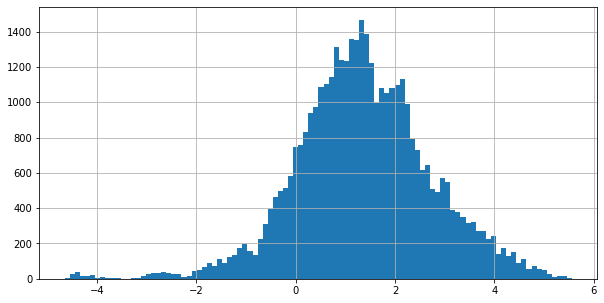

In [ ]:
## histogram of values of market1 data
melt1_['Values'].hist(bins=100, figsize=(10,5))

In [ ]:
melt1__ = melt1_.drop(columns='Date')
melt1__.head()

,ID,Values,month,year,day_of_week,day_of_year,Last_Week_Values,Last_Week_Diff
800,2,0.196549,6,2020,4,157,0.636462,-0.287025
801,2,0.204878,6,2020,5,158,0.646727,-0.249630
802,2,0.217357,6,2020,6,159,0.671035,-0.188503
803,2,0.278475,6,2020,0,160,0.693654,-0.121652
804,2,0.340230,6,2020,1,161,0.732132,-0.097591


In [ ]:
melt1_d = melt1__.copy()
melt1_d2 = melt1__.copy()

* Error Validation from Light gradient boosting Regressor

In [ ]:
mean_error = []
for ID in range(80,100):
    train = melt1_d[melt1_d['ID'] < ID]
    val = melt1_d[melt1_d['ID'] == ID]

    xtr, xts = train.drop(['Values'], axis=1), val.drop(['Values'], axis=1)
    ytr, yts = train['Values'].values, val['Values'].values

    mdl = LGBMRegressor(n_estimators=50, learning_rate=0.01, n_jobs=-1)
    mdl.fit(xtr, ytr)

    p = np.expm1(mdl.predict(xts))

    error = rmse(yts, p)
    # print('Week %d - Error %.5f' % (ID, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Mean Error = 3.14136


* Error Validation from Random Forest Regressor

In [ ]:
mean_error = []
for ID in range(80,100):
    train = melt1_d2[melt1_d2['ID'] < ID]
    val = melt1_d2[melt1_d2['ID'] == ID]

    xtr, xts = train.drop(['Values'], axis=1), val.drop(['Values'], axis=1)
    ytr, yts = train['Values'].values, val['Values'].values

    mdl = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=123)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmse(yts, p)
    # print('Week %d - Error %.5f' % (ID, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Mean Error = 1.76579


Prediction Vs. Original values plot from Random Forest Regressor as it gives least validation error.

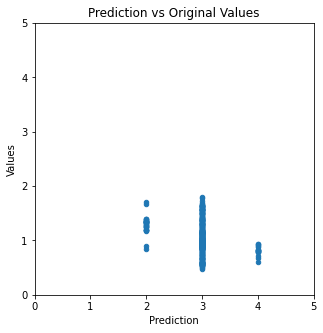

In [ ]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Values', figsize=(5,5), title='Prediction vs Original Values', 
                 ylim=(0,5), xlim=(0,5))

It can be seen from the graph that the prediction is not appropriate for all the data points and could be improved accordingly. 

## Training the model for Time Series Analysis on market1 series

!! This cell might take 30 minutes to execute !!

In [ ]:
from pycaret.regression import *
from tqdm import tqdm
all_ts = melt1['ID'].unique()

all_results = []
final_model = {}

## Warning !! Approximate execution time 30mins
for i in tqdm(all_ts):
    
    df_subset = melt1[melt1['ID'] == i]
    
    # initialize setup from pycaret.regression
    s = setup(df_subset, target = 'Values', train_size = 0.8,
              data_split_shuffle = False, fold_strategy = 'timeseries', fold = 5,
              ignore_features = ['Date', 'ID'],
              numeric_features = ['day_of_year', 'year'],
              categorical_features = ['month', 'day_of_week'],
              silent = True, verbose = False, session_id = 123)
    
    # compare all models and select best one based on MAE
    best_model = compare_models(sort = 'MAE', verbose=False)
    
    # capture the compare result grid and store best model in list
    p = pull().iloc[0:1]
    p['ID'] = str(i)
    all_results.append(p)
    
    # finalize model i.e. fit on entire data including test set
    f = finalize_model(best_model)
    
    # attach final model to a dictionary
    final_model[i] = f
    
    # save transformation pipeline and model as pickle file 
    save_model(f, model_name='trained_models_' + str(i), verbose=False)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:1

In [ ]:
## Production of Training Results
concat_results = pd.concat(all_results,axis=0)
concat_results.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),ID
huber,Huber Regressor,0.3398,0.2547,0.4050,-1.7470,0.1793,0.2591,0.038,0
ada,AdaBoost Regressor,0.2976,0.1896,0.3882,-1.4747,0.1521,0.1663,0.060,1
ada,AdaBoost Regressor,0.1872,0.0790,0.2647,-0.8863,0.1260,0.1496,0.060,2
par,Passive Aggressive Regressor,0.2835,0.1653,0.3283,-3.1115,0.0972,0.1170,0.016,3
xgboost,Extreme Gradient Boosting,0.1579,0.0753,0.2233,-1.0117,0.0991,0.1864,2.600,4


In [ ]:
## printing the start and end data for the prediction stage
print(melt1['Date'].min())
print(melt1['Date'].max())

2020-06-05 00:00:00
2021-07-09 00:00:00


In [ ]:
# create a date range from 2020 to 2021
all_dates = pd.date_range(start='2020-06-05', end = '2021-12-31', freq = 'D')
# create empty dataframe
score_df = pd.DataFrame()
# add columns to dataset
score_df['Date'] = all_dates
score_df['month'] = [i.month for i in score_df['Date']]
score_df['year'] = [i.year for i in score_df['Date']]
score_df['day_of_week'] = [i.dayofweek for i in score_df['Date']]
score_df['day_of_year'] = [i.dayofyear for i in score_df['Date']]
score_df.head()

,Date,month,year,day_of_week,day_of_year
0,2020-06-05,6,2020,4,157
1,2020-06-06,6,2020,5,158
2,2020-06-07,6,2020,6,159
3,2020-06-08,6,2020,0,160
4,2020-06-09,6,2020,1,161


In [ ]:
melt1.head()

,Date,ID,Values,month,year,day_of_week,day_of_year
0,2020-06-05,0,0.923487,6,2020,4,157
1,2020-06-06,0,0.896356,6,2020,5,158
2,2020-06-07,0,0.859538,6,2020,6,159
3,2020-06-08,0,0.815306,6,2020,0,160
4,2020-06-09,0,0.829723,6,2020,1,161


## Prediction on Future dates

In [ ]:
from pycaret.regression import load_model, predict_model
all_score_df = []
for i in tqdm(melt1['ID'].unique()):
    l = load_model('trained_models_' + str(i), verbose=False)
    p = predict_model(l, data=score_df)
    p['ID'] = i
    all_score_df.append(p)
concat_df = pd.concat(all_score_df, axis=0)
concat_df.head()

100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


,Date,month,year,day_of_week,day_of_year,Label,ID
0,2020-06-05,6,2020,4,157,2.003990,0
1,2020-06-06,6,2020,5,158,2.005802,0
2,2020-06-07,6,2020,6,159,2.002518,0
3,2020-06-08,6,2020,0,160,1.982972,0
4,2020-06-09,6,2020,1,161,1.989458,0


In [ ]:
final_df = pd.merge(concat_df, melt1, how = 'left', left_on=['Date', 'ID'], right_on = ['Date', 'ID'])
final_df.head()

,Date,month_x,year_x,day_of_week_x,day_of_year_x,Label,ID,Values,month_y,year_y,day_of_week_y,day_of_year_y
0,2020-06-05,6,2020,4,157,2.003990,0,0.923487,6.0,2020.0,4.0,157.0
1,2020-06-06,6,2020,5,158,2.005802,0,0.896356,6.0,2020.0,5.0,158.0
2,2020-06-07,6,2020,6,159,2.002518,0,0.859538,6.0,2020.0,6.0,159.0
3,2020-06-08,6,2020,0,160,1.982972,0,0.815306,6.0,2020.0,0.0,160.0
4,2020-06-09,6,2020,1,161,1.989458,0,0.829723,6.0,2020.0,1.0,161.0


In [ ]:
final_df_=final_df.drop(columns=['month_y','year_y','day_of_week_y','day_of_year_y','month_x',	'year_x',	'day_of_week_x',	'day_of_year_x', 'Values' ])
## Final Predicted Values for all the IDs
final_df_.head()

,Date,Label,ID
0,2020-06-05,2.003990,0
1,2020-06-06,2.005802,0
2,2020-06-07,2.002518,0
3,2020-06-08,1.982972,0
4,2020-06-09,1.989458,0


In [ ]:
g=final_df_.groupby('Date')
result= g.agg({'Label':lambda x:x.tolist()})
id_df=result.Label.apply(lambda x:pd.Series(x))
id_cols=['ID'+str(x) for x in range(len(id_df.columns))]
id_df.columns=id_cols
id_df.reset_index(inplace=True)
id_df= id_df.rename(columns = {'index':'Date'})
id_df.head()

,Date,ID0,ID1,ID2,ID3,ID4,ID5,ID6,ID7,ID8,ID9,ID10,ID11,ID12,ID13,ID14,ID15,ID16,ID17,ID18,ID19,ID20,ID21,ID22,ID23,ID24,ID25,ID26,ID27,ID28,ID29,ID30,ID31,ID32,ID33,ID34,ID35,ID36,ID37,ID38,...,ID60,ID61,ID62,ID63,ID64,ID65,ID66,ID67,ID68,ID69,ID70,ID71,ID72,ID73,ID74,ID75,ID76,ID77,ID78,ID79,ID80,ID81,ID82,ID83,ID84,ID85,ID86,ID87,ID88,ID89,ID90,ID91,ID92,ID93,ID94,ID95,ID96,ID97,ID98,ID99
0,2020-06-05,2.003990,0.685768,0.33062,2.383710,-0.415087,0.121955,1.707502,0.293712,1.799721,1.373895,0.427035,1.755114,0.345378,2.410061,1.514719,1.439180,1.210489,0.451440,0.206916,1.157083,-0.432605,1.367689,1.797663,1.875952,1.433188,2.392530,3.298478,-0.463285,1.738910,1.046822,1.872154,1.151534,1.204377,1.324566,1.508475,0.190318,1.501915,1.152744,1.592748,...,1.978961,0.878934,1.022290,2.015868,1.920647,-0.623482,0.165198,0.557732,1.504775,1.093218,0.558566,1.718030,2.372662,0.373477,1.276336,1.210172,2.487341,1.195803,1.660002,0.635428,0.791219,0.751093,0.766943,0.101214,1.850678,1.368740,2.704010,-0.463636,2.623398,-0.158252,1.293415,1.553668,2.075854,2.306605,2.65015,1.407952,1.457979,1.412149,1.432395,1.079595
1,2020-06-06,2.005802,0.685768,0.33062,2.385568,-0.461915,0.177914,1.716453,0.315517,1.799721,1.427141,0.447637,1.423943,0.328805,1.876989,1.458282,1.437530,1.210011,0.498291,0.206916,1.170249,-0.462239,1.368289,1.797663,1.879791,1.433188,2.324517,2.942717,-0.423821,1.715497,1.046822,1.955155,1.144029,1.204377,1.289211,1.521704,0.191305,1.490567,1.323591,1.596579,...,1.924979,0.961187,1.248006,2.073854,2.048992,-0.618703,0.126044,0.552045,1.508753,1.485031,0.546818,1.661485,2.361219,0.376730,1.282397,1.246477,2.505917,1.190817,1.665735,0.571226,0.785454,0.751999,0.869094,0.074626,1.820870,1.401304,2.202387,-0.467929,2.639905,0.006994,1.339739,1.552158,2.111017,2.330013,2.65015,1.394495,2.014655,1.411112,1.453486,1.049957
2,2020-06-07,2.002518,0.685768,0.33062,2.387427,-0.537060,0.246431,1.726635,0.318119,1.838659,1.458966,0.486845,1.401371,0.339943,1.844441,1.417075,1.435100,1.237759,0.514503,0.206916,1.186441,-0.467723,1.446805,1.797663,1.883631,1.433188,2.300970,2.970065,-0.419168,1.658389,1.046822,1.974506,1.165610,1.204377,1.287226,1.515470,0.192292,1.449811,1.384747,1.622107,...,1.853849,0.973409,1.265576,2.088712,2.129689,-0.600619,0.124775,0.568226,1.531811,1.439778,0.478685,1.623826,2.345369,0.387527,1.293016,1.196433,2.544278,1.195803,1.677675,0.484327,0.758734,0.752904,0.901518,0.063903,1.749294,1.360739,2.234246,-0.423279,2.634403,-0.001741,1.294171,1.564717,2.197938,2.378117,2.65015,1.387116,2.013849,1.425993,1.430801,1.042166
3,2020-06-08,1.982972,0.685768,0.33062,2.389290,-0.576028,0.233917,1.714130,0.327056,1.858995,1.459995,0.509144,1.360624,0.347440,1.817202,1.427483,1.419036,1.260652,0.498616,0.195751,1.193534,-0.491300,1.528409,1.797663,1.887471,1.433188,2.264298,2.986370,-0.450077,1.604617,1.046822,1.938220,1.166466,1.204377,1.284791,1.515542,0.193280,1.383657,1.419048,1.613163,...,1.833078,0.957312,1.270927,2.093057,2.131455,-0.581248,0.188889,0.586646,1.556077,1.400101,0.417631,1.627699,2.356850,0.378882,1.294491,1.103553,2.575032,1.198041,1.655560,0.392840,0.739936,0.753808,0.878951,0.080112,1.660609,1.323037,2.263503,-0.372779,2.697361,0.005795,1.242579,1.570622,2.306575,2.413993,2.65015,1.398632,2.002131,1.484285,1.429988,1.021791
4,2020-06-09,1.989458,0.685768,0.33062,2.391149,-0.566643,0.143512,1.729777,0.342722,1.882802,1.426460,0.505890,1.336087,0.333684,1.808541,1.431031,1.410193,1.310327,0.435727,0.195751,1.205555,-0.505613,1.540516,1.797663,1.891311,1.433188,2.229490,2.981786,-0.429727,1.597818,1.046822,1.913243,1.142324,1.232704,1.226430,1.515793,0.194269,1.369617,1.425834,1.604811,...,1.837349,0.998171,1.260648,2.100519,2.072239,-0.571649,0.258922,0.612800,1.583020,1.383015,0.397284,1.650187,2.339794,0.360833,1.276567,1.034235,2.624639,1.193712,1.655559,0.360715,0.728776,0.754713,0.863563,0.089739,1.629734,1.264461,2.267084,-0.345138,2.776338,0.026708,1.207762,1.577697,2.387969,2.425191,2

In [ ]:
start_date = "2021-07-10"
end_date = "2021-07-29"
after_start_date = id_df["Date"] >= start_date
before_end_date = id_df["Date"] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates1 = id_df.loc[between_two_dates]
filtered_dates1

,Date,ID0,ID1,ID2,ID3,ID4,ID5,ID6,ID7,ID8,ID9,ID10,ID11,ID12,ID13,ID14,ID15,ID16,ID17,ID18,ID19,ID20,ID21,ID22,ID23,ID24,ID25,ID26,ID27,ID28,ID29,ID30,ID31,ID32,ID33,ID34,ID35,ID36,ID37,ID38,...,ID60,ID61,ID62,ID63,ID64,ID65,ID66,ID67,ID68,ID69,ID70,ID71,ID72,ID73,ID74,ID75,ID76,ID77,ID78,ID79,ID80,ID81,ID82,ID83,ID84,ID85,ID86,ID87,ID88,ID89,ID90,ID91,ID92,ID93,ID94,ID95,ID96,ID97,ID98,ID99
400,2021-07-10,1.194968,3.145705,2.319925,2.448020,1.534290,4.634708,2.151010,-0.503664,5.045824,1.740965,-1.766571,1.239882,-0.071545,1.032540,1.260811,0.455211,5.093836,-0.397696,-0.388279,1.036257,-0.208838,2.032243,3.032945,2.006503,3.107645,4.527550,2.390819,-0.079280,0.650257,1.542766,1.723595,3.916021,0.672621,1.531767,1.030726,0.223923,-0.299775,1.501618,2.594638,...,3.605212,1.087500,1.805583,1.188041,0.830729,-0.408014,2.743191,1.925946,1.141589,1.772878,0.662544,-1.228913,3.350467,3.149356,0.677406,0.175224,4.684795,0.142581,0.271304,-0.367274,0.651043,0.782184,0.839377,0.846438,-1.240546,3.411679,1.697632,-2.516290,3.825068,-0.116349,3.451354,2.510799,1.53079,4.650184,3.565246,2.040724,2.059438,1.422728,3.71317,0.796561
401,2021-07-11,1.191684,3.145705,2.319925,2.449879,1.522412,4.634449,2.171105,-0.540258,5.045824,1.679407,-1.766247,1.253937,-0.076781,1.045047,1.262370,0.426634,5.085968,-0.360000,-0.388279,1.026562,-0.203110,2.031425,3.032945,2.010343,3.107645,4.540642,2.408381,-0.084738,0.650257,1.542766,1.723595,3.916021,0.672621,1.531767,1.033565,0.224909,-0.254047,1.489297,2.594689,...,3.556897,1.087500,1.860747,1.173141,0.835891,-0.404318,2.743191,1.925946,1.146723,1.765999,0.667582,-1.228913,3.338783,3.149356,0.688316,0.185408,4.646101,0.139683,0.269213,-0.345009,0.618214,0.783088,0.874548,0.860491,-1.236730,3.411679,1.716726,-2.516290,3.896886,-0.105992,3.465476,2.479723,1.53079,4.656866,3.565246,2.073376,2.004963,1.434964,3.71317,0.804830
402,2021-07-12,1.172138,3.145705,2.319925,2.451742,1.534751,4.624626,2.145642,-0.538117,5.045824,1.699430,-1.767985,1.070486,0.006769,0.582430,1.248610,0.413277,5.089755,-0.348945,-0.388279,0.991303,-0.208743,2.029777,3.032945,2.014183,3.107645,4.552275,2.013122,-0.093957,0.650257,1.542766,1.723595,3.916021,0.672621,1.535435,1.033565,0.225897,-0.213944,1.728799,2.608308,...,3.530334,1.087500,2.142504,1.189074,0.829172,-0.384545,2.743191,1.925946,1.155387,2.113209,0.680275,-1.228913,3.321354,3.149356,0.702929,0.193880,4.623511,0.147567,0.264374,-0.331810,0.610821,0.783993,0.892268,0.871460,-1.232347,3.500447,1.280396,-2.516290,3.822880,0.084988,3.465150,2.495067,1.53079,4.653821,3.565246,2.271395,2.463792,1.485094,3.71317,0.818922
403,2021-07-13,1.178625,3.145705,2.319925,2.453602,1.531016,4.620164,2.147532,-0.469556,5.045824,1.712886,-1.778423,1.090258,0.024288,0.591130,1.373668,0.404994,5.098404,-0.341704,-0.388279,0.983365,-0.202839,2.038126,3.032945,2.018022,3.107645,4.541162,2.039821,-0.090643,0.650257,1.542766,1.723595,3.889374,0.672621,1.559709,1.033994,0.226886,-0.252736,1.765727,2.604566,...,3.520817,1.087500,2.199858,1.190824,0.823518,-0.385234,2.743191,1.925946,1.159835,2.120011,0.680879,-1.228913,3.301632,3.149356,0.696363,0.184717,4.614277,0.147567,0.248273,-0.301494,0.565087,0.784897,0.885412,0.853876,-1.224552,3.411679,1.304530,-2.516290,3.843416,0.102847,3.477788,2.494877,1.53079,4.683957,3.565246,2.279615,2.370000,1.486435,3.71317,0.805913
404,2021-07-14,1.183699,3.145705,2.319925,2.455464,1.533598,4.611665,2.194170,-0.515669,5.045824,1.728698,-1.771369,1.114014,0.055317,0.604612,1.410444,0.399645,5.084960,-0.341658,-0.388279,0.912739,-0.195026,2.031897,3.032945,2.021862,3.107645,4.549128,2.062971,-0.083446,0.650257,1.542766,1.690942,3.916021,0.672621,1.535435,1.029145,0.227873,-0.264933,1.822470,2.610134,...,3.531788,1.087500,2.259152,1.160572,0.817741,-0.389134,2.743191,1.925946,1.153891,2.131757,0.748680,-1.228913,3.309507,3.186109,0.665058,0.191770,4.614724,0.147567,0.254916,-0.308509,0.520822,0.785801,0.868424,0.850611,-1.226796,3.411679,1.327172,-2.554103,3.90762

In [ ]:
# saving the dataframe to csv file
filtered_dates1.to_csv('market1_pred.csv')
# dowloading the file to local harddrive
from google.colab import files
files.download('market1_pred.csv')  ## downloads the file to local harddrive 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Analysis on market2 data

Similar nalaysisanalysis have been carried out on market2 data and forcasts have been produced for future dates

In [ ]:
melt2_ = melt2.copy()
melt2_['Last_Week_Values'] = melt2_.groupby(['Date'])['Values'].shift()
melt2_['Last_Week_Diff'] = melt2_.groupby(['Date'])['Last_Week_Values'].diff()
melt2_ = melt2_.dropna()
melt2_.head()

,Date,ID,Values,month,year,day_of_week,day_of_year,Last_Week_Values,Last_Week_Diff
800,2020-06-05,102,-0.298204,6,2020,4,157,2.669076,1.633006
801,2020-06-06,102,-0.208072,6,2020,5,158,2.635252,1.640618
802,2020-06-07,102,-0.111820,6,2020,6,159,2.577019,1.676495
803,2020-06-08,102,0.016855,6,2020,0,160,2.539091,1.690572
804,2020-06-09,102,0.058595,6,2020,1,161,2.553629,1.767149


In [ ]:
mean_error = []
for ID in range(180,200):
    train = melt2_[melt2_['ID'] < ID]
    val = melt2_[melt2_['ID'] == ID]

    p = val['Last_Week_Values'].values

    error = rmse(val['Values'].values, p)
    # print('ID %d - Error %.5f' % (ID, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Mean Error = 2.06660


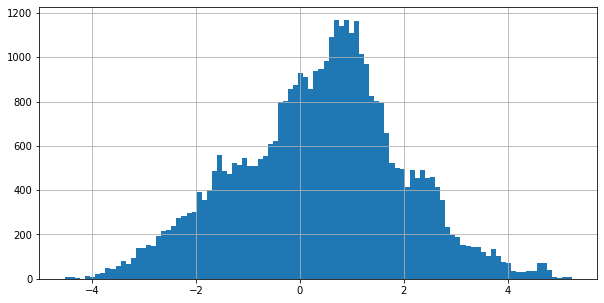

In [ ]:
## histogram of values of market2 data
melt2_['Values'].hist(bins=100, figsize=(10,5))

In [ ]:
melt2__ = melt2_.drop(columns='Date')
melt2__.head()

,ID,Values,month,year,day_of_week,day_of_year,Last_Week_Values,Last_Week_Diff
800,102,-0.298204,6,2020,4,157,2.669076,1.633006
801,102,-0.208072,6,2020,5,158,2.635252,1.640618
802,102,-0.111820,6,2020,6,159,2.577019,1.676495
803,102,0.016855,6,2020,0,160,2.539091,1.690572
804,102,0.058595,6,2020,1,161,2.553629,1.767149


In [ ]:
melt2_d = melt2__.copy()
melt2_d2 = melt2__.copy()

In [ ]:
mean_error = []
for ID in range(180,200):
    train = melt2_d[melt2_d['ID'] < ID]
    val = melt2_d[melt2_d['ID'] == ID]

    xtr, xts = train.drop(['Values'], axis=1), val.drop(['Values'], axis=1)
    ytr, yts = train['Values'].values, val['Values'].values

    mdl = LGBMRegressor(n_estimators=50, learning_rate=0.01, n_jobs=-1)
    mdl.fit(xtr, ytr)

    p = np.expm1(mdl.predict(xts))

    error = rmse(yts, p)
    # print('ID %d - Error %.5f' % (ID, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Mean Error = 1.82732


In [ ]:
mean_error = []
for ID in range(180,200):
    train = melt2_d2[melt2_d2['ID'] < ID]
    val = melt2_d2[melt2_d2['ID'] == ID]

    xtr, xts = train.drop(['Values'], axis=1), val.drop(['Values'], axis=1)
    ytr, yts = train['Values'].values, val['Values'].values

    mdl = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=123)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmse(yts, p)
    # print('ID %d - Error %.5f' % (ID, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Mean Error = 2.07694


Prediction Vs. Original values plot from Random Forest Regressor as it gives the best fit on market2 data.

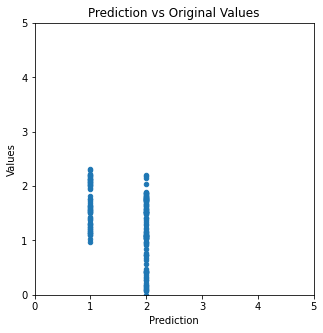

In [ ]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Values', figsize=(5,5), title='Prediction vs Original Values', 
                 ylim=(0,5), xlim=(0,5))

## Training the model for Time Series Analysis on market2 series

!! This cell might take 30 minutes to execute !!

In [ ]:
from pycaret.regression import *
from tqdm import tqdm
all_ts = melt2['ID'].unique()


all_results = []
final_model = {}

## Warning !! Approximate execution time 30mins
for i in tqdm(all_ts):
    
    df_subset = melt2[melt2['ID'] == i]
    
    # initialize setup from pycaret.regression
    s = setup(df_subset, target = 'Values', train_size = 0.8,
              data_split_shuffle = False, fold_strategy = 'timeseries', fold = 5,
              ignore_features = ['Date', 'ID' ],
              numeric_features = ['day_of_year', 'year'],
              categorical_features = ['month', 'day_of_week'],
              silent = True, verbose = False, session_id = 123)
    
    # compare all models and select best one based on MAE
    best_model = compare_models(sort = 'MAE', verbose=False)
    
    # capture the compare result grid and store best model in list
    p = pull().iloc[0:1]
    p['ID'] = str(i)
    all_results.append(p)
    
    # finalize model i.e. fit on entire data including test set
    f = finalize_model(best_model)
    
    # attach final model to a dictionary
    final_model[i] = f
    
    # save transformation pipeline and model as pickle file 
    save_model(f, model_name='trained_models_' + str(i), verbose=False)

Streaming output truncated to the last 5000 lines.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
 34%|███▍      | 34/100 [11:02<20:38, 18.76s/it]/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:1254: FutureWarning: the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:1262: FutureWarning: the n_classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:1254: FutureWarning: the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning

In [ ]:
concat_results = pd.concat(all_results,axis=0)
concat_results.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),ID
xgboost,Extreme Gradient Boosting,0.2951,0.1931,0.4022,-4.3495,0.1621,0.3640,3.630,100
gbr,Gradient Boosting Regressor,0.1681,0.0514,0.2158,-0.3629,0.0549,0.0572,0.048,101
et,Extra Trees Regressor,0.6276,0.6573,0.6998,-6.3234,0.2647,0.2955,0.456,102
ada,AdaBoost Regressor,0.2207,0.0846,0.2793,-0.4019,0.0758,0.0833,0.050,103
dt,Decision Tree Regressor,0.4533,0.3930,0.5381,-2.0929,0.1662,0.5881,0.016,104


In [ ]:
## printing the start and end data for the prediction stage
print(melt2['Date'].min())
print(melt2['Date'].max())

2020-06-05 00:00:00
2021-07-09 00:00:00


In [ ]:
melt2.head()

,Date,ID,Values,month,year,day_of_week,day_of_year
0,2020-06-05,100,1.036069,6,2020,4,157
1,2020-06-06,100,0.994634,6,2020,5,158
2,2020-06-07,100,0.900524,6,2020,6,159
3,2020-06-08,100,0.848519,6,2020,0,160
4,2020-06-09,100,0.786480,6,2020,1,161


In [ ]:
# create a date range from 2020 to 2021
all_dates = pd.date_range(start='2020-06-05', end = '2021-12-31', freq = 'D')
# create empty dataframe
score_df = pd.DataFrame()
# add columns to dataset
score_df['Date'] = all_dates
score_df['month'] = [i.month for i in score_df['Date']]
score_df['year'] = [i.year for i in score_df['Date']]
score_df['day_of_week'] = [i.dayofweek for i in score_df['Date']]
score_df['day_of_year'] = [i.dayofyear for i in score_df['Date']]
# score_df['Last_Week_Values'] = [i.dayofyear*0 for i in score_df['Date']]
# score_df['Last_Week_Diff'] = [i.dayofyear*0 for i in score_df['Date']]
score_df.head()

,Date,month,year,day_of_week,day_of_year
0,2020-06-05,6,2020,4,157
1,2020-06-06,6,2020,5,158
2,2020-06-07,6,2020,6,159
3,2020-06-08,6,2020,0,160
4,2020-06-09,6,2020,1,161


## Prediction on future dates

In [ ]:
from pycaret.regression import load_model, predict_model
all_score_df_2 = []
for i in tqdm(melt2['ID'].unique()):
    l = load_model('trained_models_' + str(i), verbose=False)
    p = predict_model(l, data=score_df)
    p['ID'] = i
    all_score_df_2.append(p)
concat_df_2 = pd.concat(all_score_df_2, axis=0)
concat_df_2.head()

100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


,Date,month,year,day_of_week,day_of_year,Label,ID
0,2020-06-05,6,2020,4,157,1.028720,100
1,2020-06-06,6,2020,5,158,0.994845,100
2,2020-06-07,6,2020,6,159,0.902963,100
3,2020-06-08,6,2020,0,160,0.847355,100
4,2020-06-09,6,2020,1,161,0.786972,100


In [ ]:
final_df_2 = pd.merge(concat_df_2, melt2, how = 'left', left_on=['Date', 'ID'], right_on = ['Date', 'ID'])
final_df_2.head()

,Date,month_x,year_x,day_of_week_x,day_of_year_x,Label,ID,Values,month_y,year_y,day_of_week_y,day_of_year_y
0,2020-06-05,6,2020,4,157,1.028720,100,1.036069,6.0,2020.0,4.0,157.0
1,2020-06-06,6,2020,5,158,0.994845,100,0.994634,6.0,2020.0,5.0,158.0
2,2020-06-07,6,2020,6,159,0.902963,100,0.900524,6.0,2020.0,6.0,159.0
3,2020-06-08,6,2020,0,160,0.847355,100,0.848519,6.0,2020.0,0.0,160.0
4,2020-06-09,6,2020,1,161,0.786972,100,0.786480,6.0,2020.0,1.0,161.0


In [ ]:
final_df_2=final_df_2.drop(columns=['month_y','year_y','day_of_week_y','day_of_year_y' ])
final_df_2.head()


,Date,month_x,year_x,day_of_week_x,day_of_year_x,Label,ID,Values
0,2020-06-05,6,2020,4,157,1.028720,100,1.036069
1,2020-06-06,6,2020,5,158,0.994845,100,0.994634
2,2020-06-07,6,2020,6,159,0.902963,100,0.900524
3,2020-06-08,6,2020,0,160,0.847355,100,0.848519
4,2020-06-09,6,2020,1,161,0.786972,100,0.786480


In [ ]:
final_df_3=final_df_2.drop(columns=['month_x',	'year_x',	'day_of_week_x',	'day_of_year_x', 'Values'])
final_df_3.head()

,Date,Label,ID
0,2020-06-05,1.028720,100
1,2020-06-06,0.994845,100
2,2020-06-07,0.902963,100
3,2020-06-08,0.847355,100
4,2020-06-09,0.786972,100


In [ ]:
g=final_df_3.groupby('Date')
result= g.agg({'Label':lambda x:x.tolist()})
id_df=result.Label.apply(lambda x:pd.Series(x))
id_cols=['ID'+str(x) for x in range(100,200)]
id_df.columns=id_cols
id_df.reset_index(inplace=True)
id_df= id_df.rename(columns = {'index':'Date'})
start_date = "2021-07-10"
end_date = "2021-07-29"
after_start_date = id_df["Date"] >= start_date
before_end_date = id_df["Date"] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates2 = id_df.loc[between_two_dates]
filtered_dates2

,Date,ID100,ID101,ID102,ID103,ID104,ID105,ID106,ID107,ID108,ID109,ID110,ID111,ID112,ID113,ID114,ID115,ID116,ID117,ID118,ID119,ID120,ID121,ID122,ID123,ID124,ID125,ID126,ID127,ID128,ID129,ID130,ID131,ID132,ID133,ID134,ID135,ID136,ID137,ID138,...,ID160,ID161,ID162,ID163,ID164,ID165,ID166,ID167,ID168,ID169,ID170,ID171,ID172,ID173,ID174,ID175,ID176,ID177,ID178,ID179,ID180,ID181,ID182,ID183,ID184,ID185,ID186,ID187,ID188,ID189,ID190,ID191,ID192,ID193,ID194,ID195,ID196,ID197,ID198,ID199
400,2021-07-10,-0.629012,3.362783,-3.074697,2.439434,-2.024759,-0.039801,-3.513445,1.518505,-1.622470,1.118505,1.235676,1.298654,-1.150765,3.931236,-0.270243,-1.619963,1.163892,3.250546,-1.952128,-0.414546,-0.987815,-0.378362,-1.919392,0.724991,-1.984993,-1.381084,0.976439,2.224516,-0.548678,-2.123903,-1.46766,-2.920303,0.374579,1.156722,-3.724103,1.345701,-0.469116,-0.331340,1.135129,...,-0.331223,-2.705535,0.041717,-2.461795,2.323503,0.639899,0.514004,-2.569425,3.103668,1.259970,-1.253906,-0.095904,-0.360731,2.467452,-0.813603,0.735245,-1.688761,-2.301634,-0.264240,0.199536,-2.590936,1.148928,0.182340,-1.785487,0.588058,-3.155273,-2.794114,-2.464122,-3.665564,0.008476,0.406939,4.674583,-2.722861,-1.642014,0.397523,0.205858,0.181485,1.319105,-1.531105,-1.989209
401,2021-07-11,-0.619542,3.361904,-3.084090,2.439434,-2.024759,-0.039801,-3.495200,1.518505,-1.624536,0.964724,1.232316,1.311745,-1.150928,3.970277,-0.270243,-1.610338,1.242473,3.250546,-1.952128,-0.414546,-0.987815,-0.378145,-1.917106,0.721494,-1.973929,-1.381084,0.976439,2.252359,-0.524462,-2.123903,-1.46766,-2.920303,0.242504,1.115873,-3.724103,1.338816,-0.454008,-0.330625,1.106494,...,-0.349654,-2.719158,0.015464,-2.472868,2.323503,0.711861,0.573443,-2.580048,3.103668,1.248230,-1.259766,-0.096152,-0.331706,2.467452,-0.807636,0.755352,-1.688761,-2.301634,-0.243655,0.225603,-2.599395,1.159980,0.224232,-1.785487,0.594645,-3.163086,-2.777920,-2.464122,-3.665564,0.008476,0.483590,4.674583,-2.727419,-1.656289,0.449835,0.216265,0.187431,1.319105,-1.537410,-1.989209
402,2021-07-12,-0.640108,3.368475,-3.116088,2.439434,-2.024759,-0.011393,-3.478119,1.518505,-1.624766,0.884914,1.255210,1.384497,-1.154979,4.011467,-0.270243,-1.600594,1.244683,3.250546,-1.952128,-0.414546,-0.987815,-0.357422,-1.918407,1.010912,-2.012968,-1.505398,0.976439,1.948354,-0.526779,-2.123903,-1.46766,-2.920303,0.166963,1.152875,-3.724103,1.338816,-0.471132,-0.334216,1.421864,...,-0.344797,-2.693200,0.004600,-2.462088,2.323503,0.901109,0.551212,-2.573116,3.103668,1.248230,-1.296387,-0.096824,0.056271,2.467452,-0.819888,0.743228,-1.688761,-2.267168,-0.243655,0.256272,-2.607854,1.162263,-0.057638,-1.785487,0.554961,-3.206055,-2.786311,-2.464122,-3.665564,0.008476,0.477765,4.674583,-2.726098,-1.622126,0.458558,0.230131,0.234024,1.319105,-1.533403,-1.989209
403,2021-07-13,-0.642022,3.368475,-3.100280,2.439434,-2.024759,-0.011393,-3.481648,1.661916,-1.614915,0.887979,1.247644,1.426530,-1.158306,4.007663,-0.270243,-1.591892,1.242473,3.250546,-1.952128,-0.423198,-0.987815,-0.339865,-1.941257,0.994496,-1.989044,-1.381084,0.976439,1.968760,-0.510509,-2.123903,-1.46766,-2.920303,0.106282,1.157326,-3.738383,1.153312,-0.481489,-0.267107,1.392840,...,-0.336548,-2.689113,0.004600,-2.460156,2.245354,0.983661,0.559999,-2.568831,3.103668,1.248230,-1.287109,-0.113918,0.050333,2.467452,-0.818023,0.720083,-1.693093,-2.301634,-0.244164,0.231114,-2.616313,1.170501,-0.020958,-1.785487,0.527459,-3.210938,-2.816555,-2.464122,-3.665564,-0.034712,0.482983,4.674583,-2.748634,-1.591093,0.455885,0.221295,0.253365,1.319105,-1.542274,-1.989209
404,2021-07-14,-0.655666,3.369427,-3.075987,2.439434,-2.024759,-0.011393,-3.506837,1.661916,-1.622908,0.878260,1.186993,1.396913,-1.169450,3.980365,-0.270243,-1.611650,1.381131,3.253503,-1.952128,-0.402383,-0.987815,-0.372794,-1.954610,0.956729,-1.946972,-1.381084,0.976439,1.968671,-0.508569,-2.123903,-1.46766,-2.920303,0.094423,1.063902,-3.724103,1.153312,-0.467504,-0.288303,1.376553,...,-0.293410,-2.658115,0.004600,-2

In [ ]:
# saving the dataframe
filtered_dates2.to_csv('market2_pred.csv')
# dowloading the file
from google.colab import files
files.download('market2_pred.csv')  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Results**

In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
# plt.style.use('fivethirtyeight')
plt.style.use('classic')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

market1_pred = final_df.copy()
market2_pred = final_df_2.copy()
print(market1_pred.shape)
print(market2_pred.shape)

(57500, 12)
(57500, 8)


In [ ]:
ID00 =  market1_pred['ID']==0
tab_ID00 = market1_pred[ID00]
tab_ID00.head()

,Date,month_x,year_x,day_of_week_x,day_of_year_x,Label,ID,Values,month_y,year_y,day_of_week_y,day_of_year_y
0,2020-06-05,6,2020,4,157,2.003990,0,0.923487,6.0,2020.0,4.0,157.0
1,2020-06-06,6,2020,5,158,2.005802,0,0.896356,6.0,2020.0,5.0,158.0
2,2020-06-07,6,2020,6,159,2.002518,0,0.859538,6.0,2020.0,6.0,159.0
3,2020-06-08,6,2020,0,160,1.982972,0,0.815306,6.0,2020.0,0.0,160.0
4,2020-06-09,6,2020,1,161,1.989458,0,0.829723,6.0,2020.0,1.0,161.0


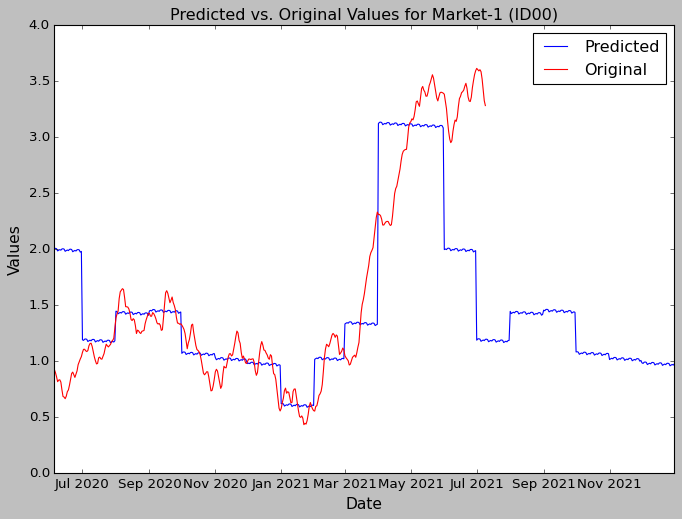

In [ ]:
plt.figure(figsize=(10, 7))
date_time = pd.to_datetime(tab_ID00['Date'])
plt.plot_date(date_time, tab_ID00['Label'], 'b-', label='Predicted')
plt.plot_date(date_time, tab_ID00['Values'], 'r-', label="Original")
plt.xlabel('Date'); plt.ylabel('Values')
plt.title('Predicted vs. Original Values for Market-1 (ID00)');
# plt.xticks(np.arange(0, 600, 75));
plt.legend(); 

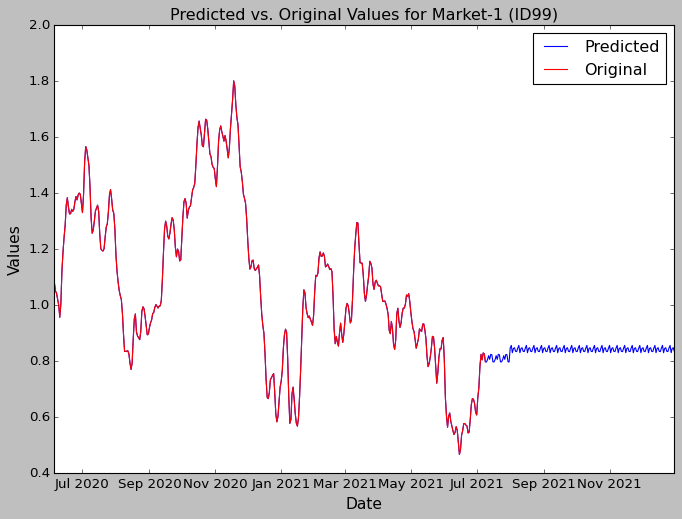

In [ ]:
ID99 =  market1_pred['ID']==99
tab_ID99 = market1_pred[ID99]
date_time = pd.to_datetime(tab_ID99['Date'])
plt.figure(figsize=(10, 7))
plt.plot(date_time, tab_ID99['Label'], 'b-', label='Predicted')
plt.plot(date_time, tab_ID99['Values'], 'r-', label="Original")
plt.xlabel('Date'); plt.ylabel('Values')
plt.title('Predicted vs. Original Values for Market-1 (ID99)');
# plt.xticks(np.arange(0, 600, 75));
plt.legend(); 

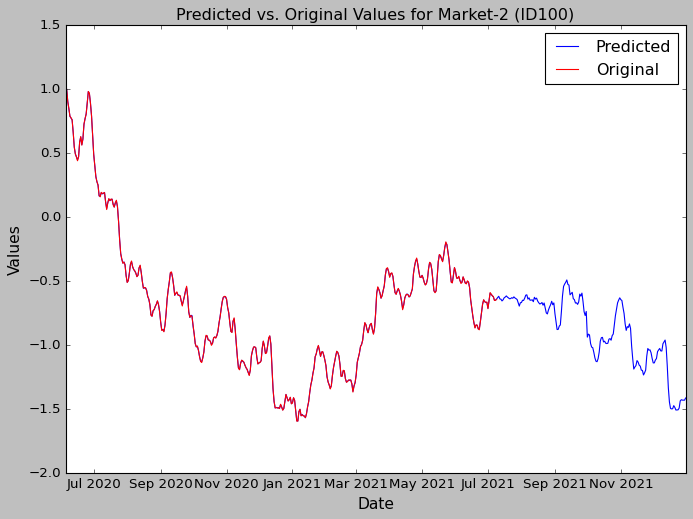

In [ ]:
ID100 =  market2_pred['ID']==100
tab_ID100 = market2_pred[ID100]
date_time = pd.to_datetime(tab_ID100['Date'])
plt.figure(figsize=(10, 7))
plt.plot(date_time, tab_ID100['Label'], 'b-', label='Predicted')
plt.plot(date_time, tab_ID100['Values'], 'r-', label="Original")
plt.xlabel('Date'); plt.ylabel('Values')
plt.title('Predicted vs. Original Values for Market-2 (ID100)');
plt.legend(); 

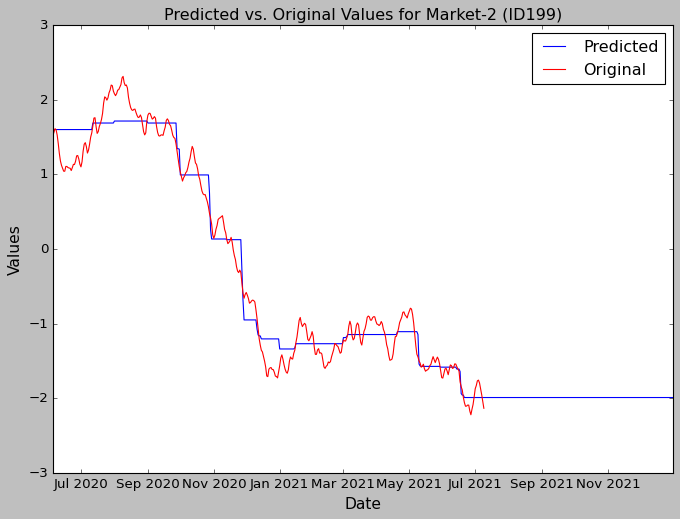

In [ ]:
ID199 =  market2_pred['ID']==199
tab_ID199 = market2_pred[ID199]
date_time = pd.to_datetime(tab_ID199['Date'])
plt.figure(figsize=(10, 7))
plt.plot(date_time, tab_ID199['Label'], 'b-', label='Predicted')
plt.plot(date_time, tab_ID199['Values'], 'r-', label="Original")
plt.xlabel('Date'); plt.ylabel('Values')
plt.title('Predicted vs. Original Values for Market-2 (ID199)');
plt.legend(); 

## Conclusion

After plotting the results for forecasting data, it has been seen that the overall trend of forecast is similar to the original trends and the forecasts are compatible with the original values for different individual IDs till the end of year 2021.  

PS.: Forecast has been shown till the end of the 2021 for better understanding and interpretation of future data. 

* **References**

1. https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/